In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(12,8)})

import requests
import zipfile
import imageio

Sklearn $\ge$ 0.19 is necessary for the efficient implementation of tsne.

In [2]:
import sklearn.manifold  
sklearn.__version__

'0.19.1'

### Pull the data from the internet and write it to a file
Don't bother running this if you've already downloaded the dataset. 

In [ ]:
#%%time
#getData = True  # Change this to false the first time you run the notebook
#if(getData): 
#    results = requests.get('https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing')
#    model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
#    model.save_word2vec_format('GoogleNews-vectors-negative300.txt', binary=False)

### Read in from file and transform into a vector space

In [ ]:
%%time
from gensim.models.keyedvectors import KeyedVectors

model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
data = model.syn0
print(data.shape)

(3000000, 300)
CPU times: user 51.1 s, sys: 8.93 s, total: 1min
Wall time: 1min 11s


/Users/leland/anaconda3/envs/umap_dev/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  after removing the cwd from sys.path.


In [ ]:
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
model.save_word2vec_format('GoogleNews-vectors-negative300.txt', binary=False)

### Now we have our data in a list of vectors.  Let's extract the object id's from the files and cast to data frame (in case we want to explore things further)

### Now let's use UMAP to embed these points into a two dimensional space.

In [5]:
num_points = 100000
selected_index = np.random.choice(data.shape[0],size=num_points, replace=False)
data = data[selected_index,:]
words = np.array(model.index2word)[selected_index]

In [37]:
fit = umap.UMAP(n_neighbors=15, random_state=42, metric='cosine')
%time u = fit.fit_transform(data)

CPU times: user 2min 57s, sys: 6.22 s, total: 3min 3s
Wall time: 2min 47s


In [38]:
embedding = pd.DataFrame({'word':words, 'x':u[:,0], 'y':u[:,1]})
embedding.to_csv("~/python/UMAP/umap_paper_notebooks/embedding_word_100_umap.csv")

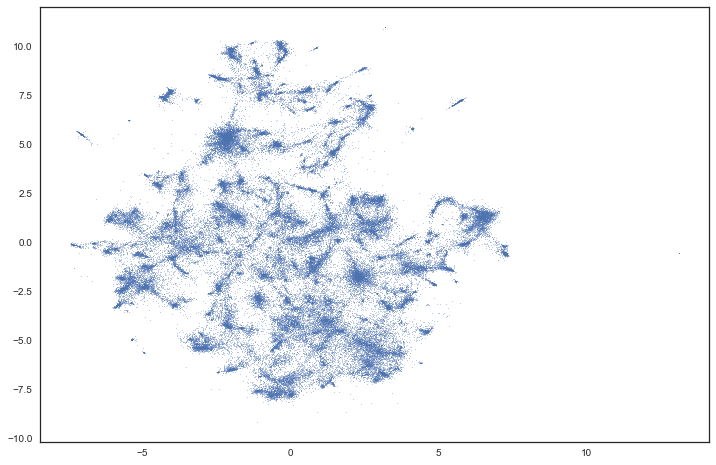

In [39]:
plt.scatter(u[:,0], u[:,1], s=0.1);

100,000 datapoints subsampled from our file results give a run time of (2min 47sec) and results in lovely topological structure.


### T-SNE

It is largely accepted that cosine distance is a good measure to use on text.  Unfortunately, t-SNE cannot be efficiently run with cosine distance.  

Fortunately, cosine distance can be approximated via L2-normalized Euclidean distance 

In [8]:
sklearn.preprocessing.normalize(data, norm='l2', copy=False);

In [43]:
fit_tsne = sklearn.manifold.TSNE(perplexity=60)
%time u_tsne = fit_tsne.fit_transform(data)

CPU times: user 2h 28min 57s, sys: 4min 33s, total: 2h 33min 31s
Wall time: 2h 30min 22s


In [44]:
embedding = pd.DataFrame({'word':words, 'x':u_tsne[:,0], 'y':u_tsne[:,1]})
embedding.to_csv("~/python/UMAP/umap_paper_notebooks/embedding_word_100_tsne.csv")

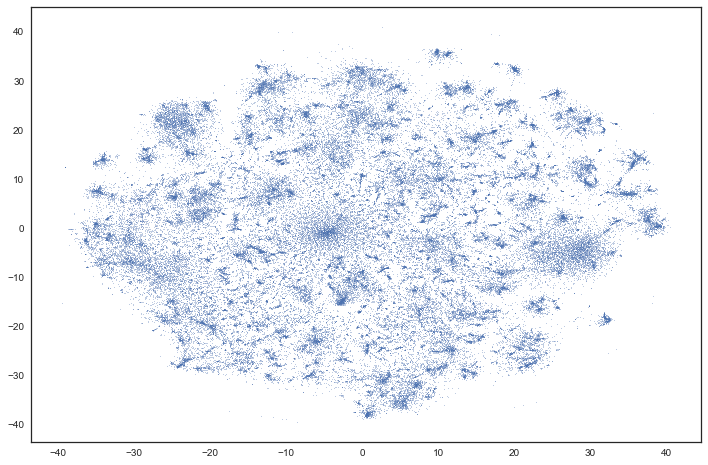

In [45]:
plt.scatter(u_tsne[:,0], u_tsne[:,1], s=0.1);

t-SNE reveals very the small clumps contained within the data but fails to highlight the relationship between these small clumps as was revealed via the UMAP algorithm earlier.

Additionally, t-SNE took 2 hours a 30 minutes to complete while UMAP finished the task in only 2 minutes and 47 seconds.

### PCA

The old standby of PCA which is blindingly fast to compute and often used as an initialization to many of the more complex algorithms.  This isn't really a competitor but instead should be thought of as a strawman.  Given that other algorithms initialize with these values one would hope that they can do better.

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
%time u_pca = pca.fit_transform(data)

CPU times: user 1.16 s, sys: 94.4 ms, total: 1.25 s
Wall time: 719 ms


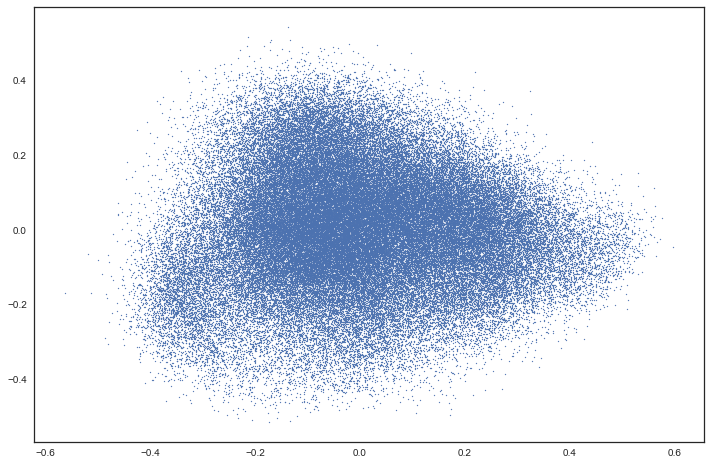

In [10]:
plt.scatter(u_pca[:,0], u_pca[:,1],  s=1);

## MDS

For old times sake we attempt to embed with multi-dimensional scaling.  Probably not worth running for the 100,000 use case.  Might try an overnight run though.

Nope killed my kernel on an 8 GB laptop on an overnight run.

In [ ]:
fit_mds = sklearn.manifold.MDS()
%time u_mds = fit_mds.fit_transform(data)

In [ ]:
plt.scatter(u_mds[:,0], u_mds[:,1], s=10);

MDS and PCA (below) should do a better job preserving global structure at the expense of sacrificying local structure.  These can be seen in the loss of loop structure in our data and the dispersal of points across our space.